# TNT ResNet Model Trained on 100 Tiled Images

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-02-15 15:19:46.762687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load VGG16 without the top (classification) layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

In [4]:
# Freeze the convolutional base (optional, speeds up training)
base_model.trainable = False

In [5]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.6)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.6)(x)
output_layer = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=output_layer)

In [6]:
lr_scheduler = ReduceLROnPlateau(
    monitor="val_accuracy",  # 🔹 Monitor validation precision instead of loss
    factor=0.5,              # Reduce LR by 50% if no improvement
    patience=3,              # Wait 3 epochs before reducing
    mode="max",              # 🔹 Higher precision is better
    min_lr=1e-6              # Don't reduce below this value
)

In [7]:
# Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [8]:
model.compile(optimizer=Adam(learning_rate=0.1), loss="binary_crossentropy", metrics=["precision"])

In [9]:
# Define directories
train_dir = '/Users/danieldobrenz/Documents/DATA SCIENCE DOCUMENTS/DATA/Magnimind/AI Imaging/MedImgIntro-WORKSHOP-main/Second Projects/TNT Project/100_no_label_256'

In [10]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [11]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),  # VGG16 input size
    batch_size=32,
    class_mode="binary",  # Binary classification
)

Found 100 images belonging to 2 classes.


In [12]:
# Load validation data
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
)

Found 100 images belonging to 2 classes.


In [13]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping]
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 657.0871 - precision: 0.6458

/opt/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,precision,val_loss,val_precision,learning_rate.
  callback.on_epoch_end(epoch, logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 709.8940 - precision: 0.6389 - val_loss: 1.9263 - val_precision: 0.0000e+00 - learning_rate: 0.1000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 15.4471 - precision: 0.8007 - val_loss: 0.7381 - val_precision: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 1.7829 - precision: 0.6743 - val_loss: 0.6604 - val_precision: 0.6900 - learning_rate: 0.1000
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 0.6612 - precision: 0.7065 - val_loss: 0.6314 - val_precision: 0.6900 - learning_rate: 0.1000
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.6389 - precision: 0.7024 - val_loss: 0.6543 - val_precision: 0.6900 - learning_rate: 0.1000
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 0.7309 - precision: 0.6921 - val_loss: 0.6208 - val_precision: 0.6900 - learning_rate: 0.1000
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.6041 - precision: 0.7412 - val_loss: 0.624

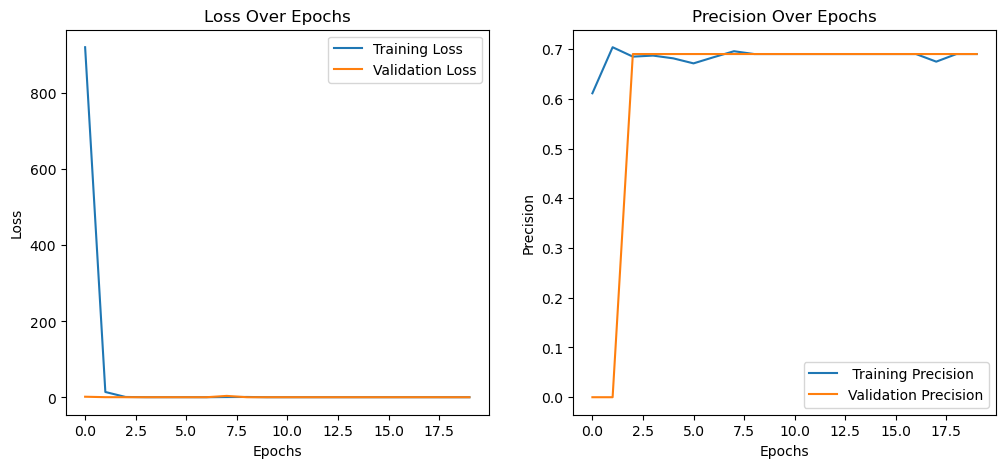

In [14]:
# Plot training & validation loss and accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Plot precision
    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'], label=" Training Precision")
    plt.plot(history.history['val_precision'], label="Validation Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.title("Precision Over Epochs")
    plt.legend()

    # Show plot
    plt.show()

# Call function to plot
plot_training_history(history)

# VGG16 Model Results

1. Learning Rate:0.1
2. Validation Split: 70%/30%
3. Batch Size: 64
4. Epochs: 20

![Alt Text](01_100_precision.png)

1. Learning Rate:0.01
2. Validation Split: 80%/20%
3. Batch Size: 64
4. Epochs: 20

![Alt Text](02_100_precision.png)

1. Learning Rate:0.0001
2. Validation Split: 80%/20%
3. Batch Size: 64
4. Epochs: 20

![Alt Text](03_100_precision.png)

1. Learning Rate:0.00001
2. Validation Split: 80%/20%
3. Batch Size: 64
4. Epochs: 50

![Alt Text](04_100_precision.png)